In [207]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import joblib

In [208]:
df = pd.read_csv('../data/homicide_cleaned.csv', parse_dates=['Incident_Date'])

#Verify Dataset
print(df.head())
print(df['Weapon_Simplified'].value_counts())
print(df.isnull().sum())

    Latitude  Longitude Incident_Date  NPA   Weapon   Age Gender   Race  Year  \
0  35.245489 -80.844187    2025-05-18  182  Handgun  17.0   Male  Black  2025   
1  35.226148 -80.825711    2025-05-18  200    Rifle  17.0   Male  Black  2025   
2  35.243351 -80.749045    2025-05-15  312  Handgun  67.0   Male  Black  2025   
3  35.249649 -80.897404    2025-05-12  385  Handgun  24.0   Male  Black  2025   
4  35.275345 -80.793498    2025-05-08  138  Handgun  29.0   Male  Black  2025   

   Month  Weekday  Hour Weapon_Simplified  
0      5        6     0               Gun  
1      5        6     0               Gun  
2      5        3     0               Gun  
3      5        0     0               Gun  
4      5        3     0               Gun  
Weapon_Simplified
Gun      762
Other     88
Blade     62
Name: count, dtype: int64
Latitude              0
Longitude             0
Incident_Date         0
NPA                   0
Weapon                0
Age                  21
Gender                

In [209]:
def age_group(age):
    if pd.isnull(age):
        return'Unknown'
    elif age < 18:
        return 'Minor'
    elif 18 <= age < 30:
        return 'Young Adult'
    elif 30 <= age < 50:
        return 'Adult'
    elif 50 <= age < 70:
        return 'Senior'
    else:
        return 'Elderly'
df['Age_Group'] = df['Age'].apply(age_group)
print(df['Age_Group'].value_counts())

Age_Group
Young Adult    415
Adult          295
Senior          91
Minor           85
Unknown         21
Elderly          5
Name: count, dtype: int64


In [210]:
#Season features

def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['Season'] = df['Month'].apply(season)

print(df['Season'].value_counts())

Season
Summer    239
Spring    233
Fall      224
Winter    216
Name: count, dtype: int64


In [211]:
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [212]:

#Feature Engineering (assuming Year, Month, Weekday already exist)
features = ['Year', 'Month', 'Weekday', 'Age_Group', 'Season', 'IsWeekend']
df_encoded = pd.get_dummies(df[features], drop_first=True)

y = df['Weapon_Simplified']

#Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(le.classes_)

X = df_encoded


['Blade' 'Gun' 'Other']


In [213]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [214]:
#Train baseline model
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [215]:
#predictions
y_pred = model.predict(X_test)

#evaluation
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=le.classes_))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       Blade       0.67      0.17      0.27        12
         Gun       0.85      0.97      0.90       153
       Other       0.20      0.06      0.09        18

    accuracy                           0.83       183
   macro avg       0.57      0.40      0.42       183
weighted avg       0.77      0.83      0.78       183

Confusion Matrix:
 [[  2  10   0]
 [  1 148   4]
 [  0  17   1]]


Year: 0.3066
Month: 0.2011
Weekday: 0.2088
IsWeekend: 0.0321
Age_Group_Elderly: 0.0124
Age_Group_Minor: 0.0426
Age_Group_Senior: 0.0463
Age_Group_Unknown: 0.0146
Age_Group_Young Adult: 0.0456
Season_Spring: 0.0319
Season_Summer: 0.0270
Season_Winter: 0.0308


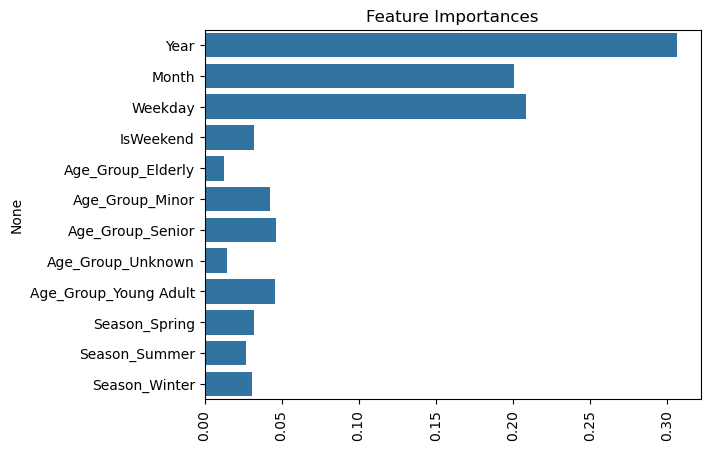

In [216]:
#Feature Importance
importances = model.feature_importances_
feature_names = X.columns

for feat, imp in zip(feature_names, importances):
    print(f'{feat}: {imp:.4f}')

#Plot feature importances
sns.barplot(x=importances, y=feature_names)
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.show()

In [217]:
#Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
#Setup GridSearch with gross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)
#Run grid search
grid_search.fit(X_train, y_train)

#Output best parameters
print('Best Parameters Found:')
print(grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters Found:
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [218]:
print(X_train.columns)
print(len(X_train.columns))
print(len(best_model.feature_importances_))


Index(['Year', 'Month', 'Weekday', 'IsWeekend', 'Age_Group_Elderly',
       'Age_Group_Minor', 'Age_Group_Senior', 'Age_Group_Unknown',
       'Age_Group_Young Adult', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')
12
12


In [219]:
#Use best model for GridSearch
best_model = grid_search.best_estimator_

#Predict and Evaluate
y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred_best))

#Updated feature importance
importances_best = pd.Series(best_model.feature_importances_, index=X_train.columns)
print(importances_best.sort_values(ascending=False))


              precision    recall  f1-score   support

       Blade       0.00      0.00      0.00        12
         Gun       0.84      1.00      0.91       153
       Other       0.00      0.00      0.00        18

    accuracy                           0.84       183
   macro avg       0.28      0.33      0.30       183
weighted avg       0.70      0.84      0.76       183

[[  0  12   0]
 [  0 153   0]
 [  0  18   0]]
Year                     0.236072
Month                    0.165317
Weekday                  0.154821
Age_Group_Young Adult    0.098747
Age_Group_Senior         0.084695
Age_Group_Minor          0.080911
Season_Spring            0.042695
IsWeekend                0.034018
Season_Winter            0.032943
Age_Group_Elderly        0.031268
Season_Summer            0.025098
Age_Group_Unknown        0.013414
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [220]:
#Retrain final model using best hyperparameters
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    random_state=42
)

final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

In [221]:
#Evaluate final locked model
y_pred_final = final_model.predict(X_test)

print(classification_report(y_test, y_pred_final, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred_final))

#Final feature importance check
importances_final = pd.Series(final_model.feature_importances_, index=X_train.columns)
print(importances_final.sort_values(ascending=False))

              precision    recall  f1-score   support

       Blade       0.00      0.00      0.00        12
         Gun       0.84      1.00      0.91       153
       Other       0.00      0.00      0.00        18

    accuracy                           0.84       183
   macro avg       0.28      0.33      0.30       183
weighted avg       0.70      0.84      0.76       183

[[  0  12   0]
 [  0 153   0]
 [  0  18   0]]
Year                     0.236072
Month                    0.165317
Weekday                  0.154821
Age_Group_Young Adult    0.098747
Age_Group_Senior         0.084695
Age_Group_Minor          0.080911
Season_Spring            0.042695
IsWeekend                0.034018
Season_Winter            0.032943
Age_Group_Elderly        0.031268
Season_Summer            0.025098
Age_Group_Unknown        0.013414
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [222]:
#Save final model
joblib.dump(final_model, '../models/final_fandom_forest.pkl')

#Save all encoders used in feature prep
joblib.dump(le, '../models/weapon_label_encoder.plk')

['../models/weapon_label_encoder.plk']